# Project 2 - HDB resale prices analysis
by Liyena Yusoff

## Contents:
* Introduction
* Problem Statement
* Data Import
* Feature Engineering
* Prepocessing
* Feature A Modeling
* Feature B Modeling
* Evaluation Metrics
* Conclusions & Recommendations
* Limitations

## Introduction
In the previous notebook, we performed data cleaning onto the [`train.csv`](datasets/train.csv) and [`test.csv`](datasets/train.csv) data and we did exploratory analysis and found out the following:
* The `floor_area_sqm` has a strong positive correlation to the `resale_price`
* The most number of resale houses sold were from Jurong West, Woodlands and Tampines
* Towns with a higher average price of 4-room flats: Bukit Timah, Bukit Merah and Bishan
* Towns with a lower average price of 4-room flats: Choa Chu Kang, Jurong West, Sembawang, Yishun
* The number of amenities around the blocks might not affect the price of a hdb unit

## Problem Statement
To investigate the amenities and facilities that cause the highest change in price for a more efficient allocation of state resources in bringing up the appeal of seemingly undervalued units.

## Data Import

In [1]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error,r2_score

import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
df = pd.read_csv('datasets/hdb_data_cleaned.csv')
df.head()

,tranc_yearmonth,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,tranc_year,...,mrt_name,bus_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,pri_sch_name,pri_sch_affiliation,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation
0,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,130.0,Improved,1987,665000.0,2012,...,Bishan,1,58.207761,415.607357,Kuo Chuan Presbyterian Primary School,1,447.894399,Kuo Chuan Presbyterian Secondary School,232,0
1,2012-04,BISHAN,4 ROOM,232,BISHAN ST 22,103.0,Model A,1992,550000.0,2012,...,Bishan,1,43.396521,389.515528,Catholic High School,1,389.515528,Catholic High School,253,1
2,2017-12,YISHUN,4 ROOM,876,YISHUN ST 81,83.0,Simplified,1987,298000.0,2017,...,Khatib,0,129.422752,401.200584,Naval Base Primary School,0,312.025435,Orchid Park Secondary School,208,0
3,2013-01,GEYLANG,3 ROOM,95,ALJUNIED CRES,65.0,Improved,1975,335000.0,2013,...,MacPherson,0,229.680469,594.128568,Saint Margaret's Primary School,1,608.838174,Geylang Methodist School,224,0
4,2018-05,HOUGANG,5 ROOM,641,HOUGANG AVE 8,120.0,Improved,1987,433000.0,2018,...,Kovan,0,46.567429,331.669318,Xinmin Primary School,0,294.826501,Bowen Secondary School,224,0


1. Train-test-split
2. Transform data - scale and/or get dummy

In [3]:
df.columns

Index(['tranc_yearmonth', 'town', 'flat_type', 'block', 'street_name',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price',
       'tranc_year', 'tranc_month', 'storey', 'hdb_age', 'max_floor_lvl',
       'commercial', 'market_hawker', 'multistorey_carpark',
       'precinct_pavilion', 'total_dwelling_units', 'planning_area',
       'mall_nearest_distance', 'mall_within_500m', 'mall_within_1km',
       'mall_within_2km', 'hawker_nearest_distance', 'hawker_within_500m',
       'hawker_within_1km', 'hawker_within_2km', 'hawker_food_stalls',
       'hawker_market_stalls', 'mrt_nearest_distance', 'mrt_name',
       'bus_interchange', 'bus_stop_nearest_distance',
       'pri_sch_nearest_distance', 'pri_sch_name', 'pri_sch_affiliation',
       'sec_sch_nearest_dist', 'sec_sch_name', 'cutoff_point', 'affiliation'],
      dtype='object')

In [4]:
df[['pri_sch_name','sec_sch_name','bus_interchange','pri_sch_affiliation', 'affiliation']]

,pri_sch_name,sec_sch_name,bus_interchange,pri_sch_affiliation,affiliation
0,Kuo Chuan Presbyterian Primary School,Kuo Chuan Presbyterian Secondary School,1,1,0
1,Catholic High School,Catholic High School,1,1,1
2,Naval Base Primary School,Orchid Park Secondary School,0,0,0
3,Saint Margaret's Primary School,Geylang Methodist School,0,1,0
4,Xinmin Primary School,Bowen Secondary School,0,0,0
...,...,...,...,...,...
134087,Evergreen Primary School,Evergreen Secondary School,1,0,0
134088,Jurong West Primary School,Boon Lay Secondary School,0,0,0
134089,Maha Bodhi School,Manjusri Secondary School,0,1,0
134090,New Town Primary School,Queensway Secondary School,0,0,0


# Feature Engineering

Three functions are defined for column interactions:<br>
* `feature_eng` for binary columns, power 2
* `feature_eng_3` for binary columns, power 3
* `feature_eng_num` for numerical columns, power 2

In [5]:
def feature_eng(df, a, b, new_col):
    
    conditions = [
    (df[a] == 0) & (df[b] == 0),
    (df[a] == 1) | (df[b] == 1),
    (df[a] == 1) & (df[b] == 1)
    ]

    values = [0, 1, 2]

# Create the new categorical column based on the conditions
    df[new_col] = np.select(conditions, values, default=0)

In [6]:
feature_eng(df, 'commercial','multistorey_carpark','comm_mscp')

feature_eng(df, 'multistorey_carpark','precinct_pavilion','mscp_pavi')

feature_eng(df, 'commercial','precinct_pavilion','comm_pavi')

feature_eng(df, 'market_hawker','precinct_pavilion','mar_haw_pavi')

In [7]:
def feature_eng_3(df, a, b,c, new_col):
    conditions = [
    (df[a] == 0) & (df[b] == 0) & (df[c] == 0),
    (df[a] == 1) & (df[b] == 1) & (df[c] == 1)
    ]

# Define the corresponding values for each condition
    values = [0, 1]

# Create the new categorical column based on the conditions
    df[new_col] = np.select(conditions, values, default=0)

In [8]:
feature_eng_3(df, 'multistorey_carpark','precinct_pavilion','market_hawker','mscp_pavi_mar_haw')

In [9]:
# feature eng numeric (non binary)

def feature_eng_num(df,a,b,new_col):
    
    df[new_col] = df[a]*df[b]

In [10]:
feature_eng_num(df, 'mrt_nearest_distance', 'pri_sch_nearest_distance','mrt_pri_dist')

feature_eng_num(df, 'hawker_food_stalls', 'hawker_market_stalls','food_mark_stalls')

## Feature selection and Modeling with Feature A

We have come up with 2 sets of features to compare where Feature A consists of interacting features.

In [11]:
features = ["food_mark_stalls","mrt_pri_dist","mar_haw_pavi","comm_pavi","mscp_pavi",
            "comm_mscp","flat_model", "floor_area_sqm","storey","hdb_age", 
            "mrt_name", "mall_nearest_distance", "precinct_pavilion",
          "hawker_food_stalls", "hawker_market_stalls", "mrt_nearest_distance", 
          "pri_sch_nearest_distance", "pri_sch_name","sec_sch_name", "tranc_year","tranc_month",
          "flat_type", "cutoff_point"]

X = df[features]
y = df['resale_price']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=30)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100569, 23)
(33523, 23)
(100569,)
(33523,)


Dummifying categorical columns such as `flat_model`,`flat_type`,`pri_sch_name`,`sec_sch_name`,`planning_area`.

In [13]:
X_train = pd.get_dummies(data= X_train, columns=['flat_model'], prefix='model')
X_train = pd.get_dummies(data= X_train, columns=['flat_type'], prefix='type')
X_train = pd.get_dummies(data=X_train, columns=['pri_sch_name'], prefix='pri')
X_train = pd.get_dummies(data=X_train, columns=['sec_sch_name'], prefix='sec')
X_train = pd.get_dummies(data=X_train, columns=['mrt_name'], prefix='mrt')


X_test = pd.get_dummies(data= X_test, columns=['flat_model'], prefix='model')
X_test = pd.get_dummies(data= X_test, columns=['flat_type'], prefix='type')
X_test = pd.get_dummies(data=X_test, columns=['pri_sch_name'], prefix='pri')
X_test = pd.get_dummies(data=X_test, columns=['sec_sch_name'], prefix='sec')
X_test = pd.get_dummies(data=X_test, columns=['mrt_name'], prefix='mrt')

Checking the shape of `X_train` and `X_test`.

In [14]:
print(X_train.shape)
print(X_test.shape)

(100569, 438)
(33523, 436)


Adding columns to both `X_train` and `X_test` for before modeling and reordering the columns in `X_test` to match those in `X_train`.

In [15]:
to_be_added = [x for x in X_test.columns if x not in X_train.columns]

for i in to_be_added:
    X_train[i]=0

print(X_train.shape)
print(X_test.shape)
print(X_train.columns)
print(X_test.columns)

(100569, 438)
(33523, 436)
Index(['food_mark_stalls', 'mrt_pri_dist', 'mar_haw_pavi', 'comm_pavi',
       'mscp_pavi', 'comm_mscp', 'floor_area_sqm', 'storey', 'hdb_age',
       'mall_nearest_distance',
       ...
       'mrt_Ubi', 'mrt_Upper Changi', 'mrt_Woodlands', 'mrt_Woodlands North',
       'mrt_Woodlands South', 'mrt_Woodleigh', 'mrt_Yew Tee',
       'mrt_Yio Chu Kang', 'mrt_Yishun', 'mrt_one-north'],
      dtype='object', length=438)
Index(['food_mark_stalls', 'mrt_pri_dist', 'mar_haw_pavi', 'comm_pavi',
       'mscp_pavi', 'comm_mscp', 'floor_area_sqm', 'storey', 'hdb_age',
       'mall_nearest_distance',
       ...
       'mrt_Ubi', 'mrt_Upper Changi', 'mrt_Woodlands', 'mrt_Woodlands North',
       'mrt_Woodlands South', 'mrt_Woodleigh', 'mrt_Yew Tee',
       'mrt_Yio Chu Kang', 'mrt_Yishun', 'mrt_one-north'],
      dtype='object', length=436)


In [16]:
to_be_added = [x for x in X_train.columns if x not in X_test.columns]

for i in to_be_added:
    X_test[i]=0

print(X_train.shape)
print(X_test.shape)
print(X_train.columns)
print(X_test.columns)

(100569, 438)
(33523, 438)
Index(['food_mark_stalls', 'mrt_pri_dist', 'mar_haw_pavi', 'comm_pavi',
       'mscp_pavi', 'comm_mscp', 'floor_area_sqm', 'storey', 'hdb_age',
       'mall_nearest_distance',
       ...
       'mrt_Ubi', 'mrt_Upper Changi', 'mrt_Woodlands', 'mrt_Woodlands North',
       'mrt_Woodlands South', 'mrt_Woodleigh', 'mrt_Yew Tee',
       'mrt_Yio Chu Kang', 'mrt_Yishun', 'mrt_one-north'],
      dtype='object', length=438)
Index(['food_mark_stalls', 'mrt_pri_dist', 'mar_haw_pavi', 'comm_pavi',
       'mscp_pavi', 'comm_mscp', 'floor_area_sqm', 'storey', 'hdb_age',
       'mall_nearest_distance',
       ...
       'mrt_Woodlands', 'mrt_Woodlands North', 'mrt_Woodlands South',
       'mrt_Woodleigh', 'mrt_Yew Tee', 'mrt_Yio Chu Kang', 'mrt_Yishun',
       'mrt_one-north', 'model_Premium Apartment Loft', 'model_Type S1'],
      dtype='object', length=438)


In [17]:
# Define the desired order of columns
column_order = X_train.columns.tolist()  # Use the column names from X_train

# Reorder the columns in X_test
X_test = X_test[column_order]

print(X_test.columns)

Index(['food_mark_stalls', 'mrt_pri_dist', 'mar_haw_pavi', 'comm_pavi',
       'mscp_pavi', 'comm_mscp', 'floor_area_sqm', 'storey', 'hdb_age',
       'mall_nearest_distance',
       ...
       'mrt_Ubi', 'mrt_Upper Changi', 'mrt_Woodlands', 'mrt_Woodlands North',
       'mrt_Woodlands South', 'mrt_Woodleigh', 'mrt_Yew Tee',
       'mrt_Yio Chu Kang', 'mrt_Yishun', 'mrt_one-north'],
      dtype='object', length=438)


## Modeling & Evaluation

We will set a baseline model - Linear Regression as a point of comparison.

### Linear Regression

In [18]:
pipe = Pipeline([('ss', StandardScaler()),
                 ('lr', LinearRegression())])

In [19]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('lr', LinearRegression())])

In [20]:
y_train_preds = pipe.predict(X_train)
y_test_preds = pipe.predict(X_test)

In [21]:
rmse_train = mean_squared_error(y_train,y_train_preds, squared=False)
rmse_test = mean_squared_error(y_test,y_test_preds, squared=False)

r2_train = r2_score(y_train,y_train_preds)
r2_test = r2_score(y_test,y_test_preds)

print("RMSE train:",round(rmse_train,3))
print("RMSE test:",round(rmse_test,3))
print("R2 train:",round(r2_train,4))
print("R2 test:",round(r2_test,4))

RMSE train: 38610.845
RMSE test: 38577.386
R2 train: 0.8991
R2 test: 0.8987


### LassoCV

In [22]:
pipe2 = Pipeline([('ss', StandardScaler()),
                 ('la', LassoCV(alphas=[0.01,0.1,2,5,100], cv=KFold(8), max_iter=10000))])

In [23]:
%%time
pipe2.fit(X_train, y_train)

/Users/liyenauseff/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1245337921873.4219, tolerance: 129672377304.79076
  model = cd_fast.enet_coordinate_descent_gram(
/Users/liyenauseff/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12642089228735.422, tolerance: 129672377304.79076
  model = cd_fast.enet_coordinate_descent_gram(
/Users/liyenauseff/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16667889511222.18, tolerance: 130181585682.88318
  model = cd_fast.enet_coordinate_descent_gram(
/Users/liyenauseff/anaconda3/lib/python3.10/

CPU times: user 1h 53min 35s, sys: 1min 19s, total: 1h 54min 55s
Wall time: 11min 55s


/Users/liyenauseff/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.410e+13, tolerance: 1.486e+11
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('ss', StandardScaler()),
                ('la',
                 LassoCV(alphas=[0.01, 0.1, 2, 5, 100],
                         cv=KFold(n_splits=8, random_state=None, shuffle=False),
                         max_iter=10000))])

In [24]:
y_train_pred = pipe2.predict(X_train)
y_test_pred = pipe2.predict(X_test)

In [25]:
rmse_train = mean_squared_error(y_train,y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test,y_test_pred, squared=False)

r2_train = r2_score(y_train,y_train_pred)
r2_test = r2_score(y_test,y_test_pred)

print("RMSE train:",round(rmse_train,3))
print("RMSE test:",round(rmse_test,3))
print("R2 train:",round(r2_train,4))
print("R2 test:",round(r2_test,4))

RMSE train: 38607.449
RMSE test: 38570.234
R2 train: 0.8991
R2 test: 0.8987


In [26]:
lasso_alp = pipe2.named_steps['la'].alpha_
lasso_alp

0.1

### RidgeCV

In [27]:
pipe3 = Pipeline([('ss', StandardScaler()),
                 ('ridge', RidgeCV(cv=KFold(8), alphas=[0.01,0.1, 2,5,100]))])

In [28]:
pipe3.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('ridge',
                 RidgeCV(alphas=[0.01, 0.1, 2, 5, 100],
                         cv=KFold(n_splits=8, random_state=None, shuffle=False)))])

In [29]:
y_train_predr = pipe3.predict(X_train)
y_test_predr = pipe3.predict(X_test)

In [30]:
rmse_train = mean_squared_error(y_train,y_train_predr, squared=False)
rmse_test = mean_squared_error(y_test,y_test_predr, squared=False)

r2_train = r2_score(y_train,y_train_predr)
r2_test = r2_score(y_test,y_test_predr)

print("RMSE train:",round(rmse_train,3))
print("RMSE test:",round(rmse_test,3))
print("R2 train:",round(r2_train,4))
print("R2 test:",round(r2_test,4))

RMSE train: 38607.481
RMSE test: 38570.206
R2 train: 0.8991
R2 test: 0.8987


In [31]:
ridge_alp = pipe3.named_steps['ridge'].alpha_
ridge_alp

5.0

## Feature selection and Modeling with Feature B

In [68]:
features = ['tranc_yearmonth',
 'flat_type',
 'floor_area_sqm',
 'flat_model',
 'storey',
 'hdb_age',
 # 'max_floor_lvl',
 'commercial',
 'market_hawker',
 'planning_area',
 'mall_nearest_distance',
 'mrt_nearest_distance',
 'pri_sch_name',
 'sec_sch_name']

X = df[features]
y = df['resale_price']

In [69]:
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X,y, test_size=0.25, random_state=30)

print(X_train_B.shape)
print(X_test_B.shape)
print(y_train_B.shape)
print(y_test_B.shape)

(100569, 13)
(33523, 13)
(100569,)
(33523,)


In [70]:
X_train_B = pd.get_dummies(data= X_train_B, columns=['flat_model'], prefix='model')
X_train_B = pd.get_dummies(data= X_train_B, columns=['flat_type'], prefix='type')
X_train_B = pd.get_dummies(data=X_train_B, columns=['pri_sch_name'], prefix='pri')
X_train_B = pd.get_dummies(data=X_train_B, columns=['sec_sch_name'], prefix='sec')
X_train_B = pd.get_dummies(data=X_train_B, columns=['planning_area'], prefix='pA')
X_train_B = pd.get_dummies(data=X_train_B, columns=['tranc_yearmonth'], prefix='ym')


X_test_B = pd.get_dummies(data= X_test_B, columns=['flat_model'], prefix='model')
X_test_B = pd.get_dummies(data= X_test_B, columns=['flat_type'], prefix='type')
X_test_B = pd.get_dummies(data=X_test_B, columns=['pri_sch_name'], prefix='pri')
X_test_B = pd.get_dummies(data=X_test_B, columns=['sec_sch_name'], prefix='sec')
X_test_B = pd.get_dummies(data=X_test_B, columns=['planning_area'], prefix='pA')
X_test_B = pd.get_dummies(data=X_test_B, columns=['tranc_yearmonth'], prefix='ym')


In [71]:
to_be_added = [x for x in X_test_B.columns if x not in X_train_B.columns]

for i in to_be_added:
    X_train_B[i]=0

print(X_train_B.shape)
print(X_test_B.shape)
print(X_train_B.columns)
print(X_test_B.columns)

(100569, 481)
(33523, 479)
Index(['floor_area_sqm', 'storey', 'hdb_age', 'commercial', 'market_hawker',
       'mall_nearest_distance', 'mrt_nearest_distance', 'model_2-room',
       'model_Adjoined flat', 'model_Apartment',
       ...
       'ym_2020-07', 'ym_2020-08', 'ym_2020-09', 'ym_2020-10', 'ym_2020-11',
       'ym_2020-12', 'ym_2021-01', 'ym_2021-02', 'ym_2021-03', 'ym_2021-04'],
      dtype='object', length=481)
Index(['floor_area_sqm', 'storey', 'hdb_age', 'commercial', 'market_hawker',
       'mall_nearest_distance', 'mrt_nearest_distance', 'model_2-room',
       'model_Adjoined flat', 'model_Apartment',
       ...
       'ym_2020-07', 'ym_2020-08', 'ym_2020-09', 'ym_2020-10', 'ym_2020-11',
       'ym_2020-12', 'ym_2021-01', 'ym_2021-02', 'ym_2021-03', 'ym_2021-04'],
      dtype='object', length=479)


In [72]:
to_be_added = [x for x in X_train_B.columns if x not in X_test_B.columns]

for i in to_be_added:
    X_test_B[i]=0

print(X_train_B.shape)
print(X_test_B.shape)
print(X_train_B.columns)
print(X_test_B.columns)

(100569, 481)
(33523, 481)
Index(['floor_area_sqm', 'storey', 'hdb_age', 'commercial', 'market_hawker',
       'mall_nearest_distance', 'mrt_nearest_distance', 'model_2-room',
       'model_Adjoined flat', 'model_Apartment',
       ...
       'ym_2020-07', 'ym_2020-08', 'ym_2020-09', 'ym_2020-10', 'ym_2020-11',
       'ym_2020-12', 'ym_2021-01', 'ym_2021-02', 'ym_2021-03', 'ym_2021-04'],
      dtype='object', length=481)
Index(['floor_area_sqm', 'storey', 'hdb_age', 'commercial', 'market_hawker',
       'mall_nearest_distance', 'mrt_nearest_distance', 'model_2-room',
       'model_Adjoined flat', 'model_Apartment',
       ...
       'ym_2020-09', 'ym_2020-10', 'ym_2020-11', 'ym_2020-12', 'ym_2021-01',
       'ym_2021-02', 'ym_2021-03', 'ym_2021-04',
       'model_Premium Apartment Loft', 'model_Type S1'],
      dtype='object', length=481)


In [73]:
# Define the desired order of columns
column_order = X_train_B.columns.tolist()  # Use the column names from X_train_B

# Reorder the columns in X_test_B
X_test_B = X_test_B[column_order]

print(X_test_B.columns)

Index(['floor_area_sqm', 'storey', 'hdb_age', 'commercial', 'market_hawker',
       'mall_nearest_distance', 'mrt_nearest_distance', 'model_2-room',
       'model_Adjoined flat', 'model_Apartment',
       ...
       'ym_2020-07', 'ym_2020-08', 'ym_2020-09', 'ym_2020-10', 'ym_2020-11',
       'ym_2020-12', 'ym_2021-01', 'ym_2021-02', 'ym_2021-03', 'ym_2021-04'],
      dtype='object', length=481)


## Modeling with Feature B and Evaluation

**Linear Regression**

In [38]:
pipe.fit(X_train_B, y_train_B)

Pipeline(steps=[('ss', StandardScaler()), ('lr', LinearRegression())])

In [39]:
y_trainB_preds = pipe.predict(X_train_B)
y_testB_preds = pipe.predict(X_test_B)

In [40]:
rmse_trainB = mean_squared_error(y_train_B,y_trainB_preds, squared=False)
rmse_testB = mean_squared_error(y_test_B,y_testB_preds, squared=False)

r2_trainB = r2_score(y_train,y_trainB_preds)
r2_testB = r2_score(y_test,y_testB_preds)

print("RMSE train:",round(rmse_trainB,3))
print("RMSE test:",round(rmse_testB,3))
print("R2 train:",round(r2_trainB,4))
print("R2 test:",round(r2_testB,4))

RMSE train: 36650.501
RMSE test: 36476.541
R2 train: 0.9091
R2 test: 0.9094


### LassoCV

In [41]:
%%time
pipe2.fit(X_train_B, y_train_B)

/Users/liyenauseff/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3385614206462.0312, tolerance: 129672377304.79076
  model = cd_fast.enet_coordinate_descent_gram(
/Users/liyenauseff/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3329590919219.3906, tolerance: 129672377304.79076
  model = cd_fast.enet_coordinate_descent_gram(
/Users/liyenauseff/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4593239396727.984, tolerance: 130181585682.88318
  model = cd_fast.enet_coordinate_descent_gram(
/Users/liyenauseff/anaconda3/lib/python3.10/

CPU times: user 2h 5min 59s, sys: 1min 17s, total: 2h 7min 17s
Wall time: 13min 14s


/Users/liyenauseff/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.328e+11, tolerance: 1.486e+11
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('ss', StandardScaler()),
                ('la',
                 LassoCV(alphas=[0.01, 0.1, 2, 5, 100],
                         cv=KFold(n_splits=8, random_state=None, shuffle=False),
                         max_iter=10000))])

In [42]:
y_trainB_pred = pipe2.predict(X_train_B)
y_testB_pred = pipe2.predict(X_test_B)

In [43]:
rmse_trainB = mean_squared_error(y_train_B,y_trainB_pred, squared=False)
rmse_testB = mean_squared_error(y_test_B,y_testB_pred, squared=False)

r2_trainB = r2_score(y_train,y_trainB_pred)
r2_testB = r2_score(y_test,y_testB_pred)

print("RMSE train:",round(rmse_trainB,3))
print("RMSE test:",round(rmse_testB,3))
print("R2 train:",round(r2_trainB,4))
print("R2 test:",round(r2_testB,4))

RMSE train: 36641.732
RMSE test: 36465.649
R2 train: 0.9091
R2 test: 0.9095


In [44]:
lasso_alp = pipe2.named_steps['la'].alpha_
lasso_alp

2.0

### RidgeCV

In [75]:
pipe3.fit(X_train_B, y_train_B)

Pipeline(steps=[('ss', StandardScaler()),
                ('ridge',
                 RidgeCV(alphas=[0.01, 0.1, 2, 5, 100],
                         cv=KFold(n_splits=8, random_state=None, shuffle=False)))])

In [76]:
y_trainB_predr = pipe3.predict(X_train_B)
y_testB_predr = pipe3.predict(X_test_B)

In [77]:
rmse_trainB = mean_squared_error(y_train_B,y_trainB_predr, squared=False)
rmse_testB = mean_squared_error(y_test_B,y_testB_predr, squared=False)

r2_trainB = r2_score(y_train,y_trainB_preds)
r2_testB = r2_score(y_test,y_testB_preds)

print("RMSE train:",round(rmse_trainB,3))
print("RMSE test:",round(rmse_testB,3))
print("R2 train:",round(r2_trainB,4))
print("R2 test:",round(r2_testB,4))

RMSE train: 36641.033
RMSE test: 36461.758
R2 train: 0.9091
R2 test: 0.9094


In [78]:
ridge_alp = pipe3.named_steps['ridge'].alpha_
ridge_alp

5.0

## Evaluation Metrics

|Feature A or B| Model       |Alpha value| R2 Score (Train) | R2 Score (Test) | RMSE (Train) | RMSE (Test) | Remarks         |
|--------------|-------------|-----------|------------------|-----------------|--------------|-------------|-----------------|
| A            | Linear Regression     |  -  |     0.8991   | 0.8987          | 38610.845    | 38577.386   | Good fit; Baseline score  |
| A            | LassoCV               |  0.1  |  0.8991    | 0.8987          | 38607.449    | 38570.234   | Good fit        |
| A            | RidgeCV               |  5  | 0.8991       | 0.8987          | 38607.481    | 38570.206   | Good fit        |
| B            | Linear Regression     |  -  |  0.9091      |0.9094           | 36650.501    | 36476.541   | Good fit        |
| B            | LassoCV               |  2  |  0.9091      |0.9095           | 36641.732     | 36465.649   | Good fit        |
| B            | RidgeCV               |  5  |  0.9091      |0.9094           | 36641.033    | 36461.758   | Good fit        |




The models performed well as the discrepancies are insignificant between the RMSE scores for each model and features. Between the two types of features, the models with Feature B predicted better with smaller RMSE values. With this, we will be using RidgeCV as the model, with features B, to predict the values from the `test_data`.

## Understanding the Coefficients

The coefficients of the features show the extent of the impact of the feature onto the `resale_price`.

In [79]:
pipe3_coef = pipe3.named_steps['ridge'].coef_

# Create a DataFrame to display the coefficients with their respective features
df_coef_pipe3 = pd.DataFrame({'Feature': X_train_B.columns, 'Coefficient': pipe3_coef})

abs_coef = [abs(x) for x in df_coef_pipe3['Coefficient']]

df_coef_pipe3['Abs_Coef']=abs_coef

In [80]:
coef_sorted = df_coef_pipe3.sort_values(by='Abs_Coef', ascending=False)
coef_sorted.head(30)

,Feature,Coefficient,Abs_Coef
0,floor_area_sqm,67604.046160,67604.046160
2,hdb_age,-53231.204692,53231.204692
6,mrt_nearest_distance,-22202.937398,22202.937398
341,pA_Bedok,18259.939945,18259.939945
1,storey,16708.528410,16708.528410
28,type_3 ROOM,-16439.515340,16439.515340
31,type_EXECUTIVE,14555.243726,14555.243726
347,pA_Choa Chu Kang,-12690.024492,12690.024492
30,type_5 ROOM,11689.734905,11689.734905
344,pA_Bukit Merah,10393.366201,10393.366201


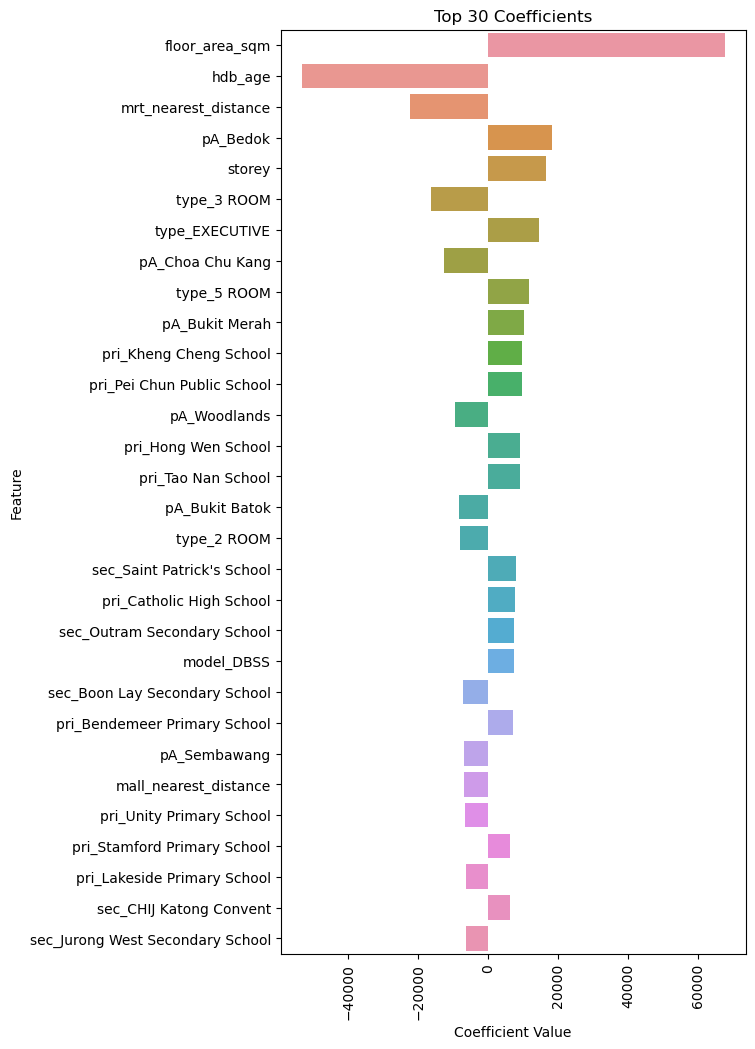

In [81]:
plt.figure(figsize=(6, 12))
sns.barplot(coef_sorted.head(30), x='Coefficient',y='Feature', orient='h')

plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 30 Coefficients')
plt.xticks(rotation=90)

plt.show()

The top amenitites that contribute to the resale prices are:
1. The size of the flat
2. The flat age
3. The distance from the block to the MRT station
4. The height of the block

Bigger flat sizes and younger blocks drive up the price of the flat. Having taller blocks also increase the value of the flat.<br>
Each square metre increase of the `floor_area_sqm` increases the `resale_price` by 67604.05.<br>
With each year, the `resale_price` decreases by 53231.20.<br>
Each unit of height of a block, the `resale_price` increases by 16708.52.

### Predicting the resale price with the test data

In [49]:
test_data = pd.read_csv('datasets/cleaned_test_data.csv')

In [50]:
test_data.columns

Index(['tranc_yearmonth', 'town', 'flat_type', 'block', 'street_name',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'tranc_year',
       'tranc_month', 'storey', 'hdb_age', 'max_floor_lvl', 'commercial',
       'market_hawker', 'multistorey_carpark', 'precinct_pavilion',
       'total_dwelling_units', 'planning_area', 'mall_nearest_distance',
       'mall_within_500m', 'mall_within_1km', 'mall_within_2km',
       'hawker_nearest_distance', 'hawker_within_500m', 'hawker_within_1km',
       'hawker_within_2km', 'hawker_food_stalls', 'hawker_market_stalls',
       'mrt_nearest_distance', 'mrt_name', 'bus_interchange',
       'bus_stop_nearest_distance', 'pri_sch_nearest_distance', 'pri_sch_name',
       'pri_sch_affiliation', 'sec_sch_nearest_dist', 'sec_sch_name',
       'cutoff_point', 'affiliation'],
      dtype='object')

In [51]:
features = ['tranc_yearmonth',
 'flat_type',
 'floor_area_sqm',
 'flat_model',
 'storey',
 'hdb_age',
 'max_floor_lvl',
 'commercial',
 'market_hawker',
 'planning_area',
 'mall_nearest_distance',
 'mrt_nearest_distance',
 'pri_sch_name',
 'sec_sch_name']

data = test_data[features]

In [52]:
data = pd.get_dummies(data= data, columns=['flat_model'], prefix='model')
data = pd.get_dummies(data= data, columns=['flat_type'], prefix='type')
data = pd.get_dummies(data=data, columns=['pri_sch_name'], prefix='pri')
data = pd.get_dummies(data=data, columns=['sec_sch_name'], prefix='sec')
data = pd.get_dummies(data=data, columns=['planning_area'], prefix='pA')
data = pd.get_dummies(data=data, columns=['tranc_yearmonth'], prefix='ym')

In [53]:
to_be_added = [x for x in X_train.columns if x not in data.columns]

for i in to_be_added:
    data[i]=0

print(X_train.shape)
print(test_data.shape)
print(X_train.columns)
print(test_data.columns)

(100569, 438)
(16737, 40)
Index(['food_mark_stalls', 'mrt_pri_dist', 'mar_haw_pavi', 'comm_pavi',
       'mscp_pavi', 'comm_mscp', 'floor_area_sqm', 'storey', 'hdb_age',
       'mall_nearest_distance',
       ...
       'mrt_Ubi', 'mrt_Upper Changi', 'mrt_Woodlands', 'mrt_Woodlands North',
       'mrt_Woodlands South', 'mrt_Woodleigh', 'mrt_Yew Tee',
       'mrt_Yio Chu Kang', 'mrt_Yishun', 'mrt_one-north'],
      dtype='object', length=438)
Index(['tranc_yearmonth', 'town', 'flat_type', 'block', 'street_name',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'tranc_year',
       'tranc_month', 'storey', 'hdb_age', 'max_floor_lvl', 'commercial',
       'market_hawker', 'multistorey_carpark', 'precinct_pavilion',
       'total_dwelling_units', 'planning_area', 'mall_nearest_distance',
       'mall_within_500m', 'mall_within_1km', 'mall_within_2km',
       'hawker_nearest_distance', 'hawker_within_500m', 'hawker_within_1km',
       'hawker_within_2km', 'hawker_food_stalls', 

/var/folders/k7/8c5x2ygj2td4rpnn786dd9480000gp/T/ipykernel_50799/366917901.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[i]=0
/var/folders/k7/8c5x2ygj2td4rpnn786dd9480000gp/T/ipykernel_50799/366917901.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[i]=0
/var/folders/k7/8c5x2ygj2td4rpnn786dd9480000gp/T/ipykernel_50799/366917901.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

In [54]:
to_be_added = [x for x in data.columns if x not in X_train.columns]

for i in to_be_added:
    X_train[i]=0

print(X_train.shape)
print(test_data.shape)
print(X_train.columns)
print(test_data.columns)

(100569, 588)
(16737, 40)
Index(['food_mark_stalls', 'mrt_pri_dist', 'mar_haw_pavi', 'comm_pavi',
       'mscp_pavi', 'comm_mscp', 'floor_area_sqm', 'storey', 'hdb_age',
       'mall_nearest_distance',
       ...
       'ym_2020-07', 'ym_2020-08', 'ym_2020-09', 'ym_2020-10', 'ym_2020-11',
       'ym_2020-12', 'ym_2021-01', 'ym_2021-02', 'ym_2021-03', 'ym_2021-04'],
      dtype='object', length=588)
Index(['tranc_yearmonth', 'town', 'flat_type', 'block', 'street_name',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'tranc_year',
       'tranc_month', 'storey', 'hdb_age', 'max_floor_lvl', 'commercial',
       'market_hawker', 'multistorey_carpark', 'precinct_pavilion',
       'total_dwelling_units', 'planning_area', 'mall_nearest_distance',
       'mall_within_500m', 'mall_within_1km', 'mall_within_2km',
       'hawker_nearest_distance', 'hawker_within_500m', 'hawker_within_1km',
       'hawker_within_2km', 'hawker_food_stalls', 'hawker_market_stalls',
       'mrt_nearest_

/var/folders/k7/8c5x2ygj2td4rpnn786dd9480000gp/T/ipykernel_50799/2526487072.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[i]=0
/var/folders/k7/8c5x2ygj2td4rpnn786dd9480000gp/T/ipykernel_50799/2526487072.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[i]=0
/var/folders/k7/8c5x2ygj2td4rpnn786dd9480000gp/T/ipykernel_50799/2526487072.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all co

In [55]:
# Define the desired order of columns
column_order = X_train.columns.tolist()  # Use the column names from X_train

# Reorder the columns in X_test
data = data[column_order]

print(data.columns)

Index(['food_mark_stalls', 'mrt_pri_dist', 'mar_haw_pavi', 'comm_pavi',
       'mscp_pavi', 'comm_mscp', 'floor_area_sqm', 'storey', 'hdb_age',
       'mall_nearest_distance',
       ...
       'ym_2020-07', 'ym_2020-08', 'ym_2020-09', 'ym_2020-10', 'ym_2020-11',
       'ym_2020-12', 'ym_2021-01', 'ym_2021-02', 'ym_2021-03', 'ym_2021-04'],
      dtype='object', length=588)


In [56]:
pipe3.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('ridge',
                 RidgeCV(alphas=[0.01, 0.1, 2, 5, 100],
                         cv=KFold(n_splits=8, random_state=None, shuffle=False)))])

In [57]:
test_data.head()

,tranc_yearmonth,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,tranc_year,tranc_month,...,mrt_name,bus_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,pri_sch_name,pri_sch_affiliation,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation
0,2012-11,YISHUN,4 ROOM,173,YISHUN AVE 7,84.0,Simplified,1987,2012,11,...,Canberra,0,75.683952,426.467910,Ahmad Ibrahim Primary School,0,156.322353,Ahmad Ibrahim Secondary School,218,0
1,2019-08,JURONG WEST,5 ROOM,986C,JURONG WEST ST 93,112.0,Premium Apartment,2008,2019,8,...,Pioneer,0,88.993058,439.756851,Jurong West Primary School,0,739.371688,Jurong West Secondary School,199,0
2,2013-10,ANG MO KIO,3 ROOM,534,ANG MO KIO AVE 10,68.0,New Generation,1980,2013,10,...,Ang Mo Kio,1,86.303575,355.882207,Jing Shan Primary School,0,305.071191,Anderson Secondary School,245,0
3,2017-10,WOODLANDS,4 ROOM,29,MARSILING DR,97.0,New Generation,1979,2017,10,...,Marsiling,0,108.459039,929.744711,Marsiling Primary School,0,433.454591,Woodlands Secondary School,188,0
4,2016-08,BUKIT BATOK,4 ROOM,170,BT BATOK WEST AVE 8,103.0,Model A,1985,2016,8,...,Chinese Garden,0,113.645431,309.926934,Princess Elizabeth Primary School,0,217.295361,Bukit Batok Secondary School,223,0


In [58]:
data.head()

,food_mark_stalls,mrt_pri_dist,mar_haw_pavi,comm_pavi,mscp_pavi,comm_mscp,floor_area_sqm,storey,hdb_age,mall_nearest_distance,...,ym_2020-07,ym_2020-08,ym_2020-09,ym_2020-10,ym_2020-11,ym_2020-12,ym_2021-01,ym_2021-02,ym_2021-03,ym_2021-04
0,0,0,0,0,0,0,84.0,8,34,877.431572,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,112.0,5,13,534.037705,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,68.0,8,41,817.050453,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,97.0,2,42,1272.737194,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,103.0,17,36,1070.963675,...,0,0,0,0,0,0,0,0,0,0


In [59]:
y_test_pred = pipe3.predict(data)

In [60]:
y_test_pred

array([14625942.54771159, 14805709.82109925, 14587292.81080606, ...,
       14674872.28212246, 14791624.68761957, 14582788.36238952])

In [61]:
df= pd.read_csv('datasets/test.csv', low_memory=False)

In [62]:
to_submit = pd.DataFrame({'id': df['id'], 'Predicted': y_test_pred})

In [63]:
to_submit.head()

,id,Predicted
0,114982,1.462594e+07
1,95653,1.480571e+07
2,40303,1.458729e+07
3,109506,1.462411e+07
4,100149,1.469374e+07


In [64]:
to_submit.to_csv('datasets/pred.csv',index=False)

## Conclusion and Recommendations

The resale prices are benchmarked based on the floor area of each type of unit. Through the model, certain areas such as Woodlands, Choa Chu Kang and Sembawang have prices lower than those in other regions, despite having the amenities and schools close to the HDB blocks. It also seems that people prefer living in taller HDB flats and near the MRT stations for easy transaportation. 

Because most towns would already have their own MRT station, one way to improve the desireability of the houses is to have easy accessibility from the blocks to the MRT stations. This could be done by increasing the frequency of feeder buses to the mrt station and improving the infrastructure around the blocks to the nearest bus stop or MRT stations such as walkways or PCN (Park Connector Networks).

## Limitations and Recommendations

The housing prices could also be affected by other factors such as the number of buses available in the district or the distance from the block to the nearest expressway, the nearest distance to a community centre (CC) and the activities held at the CCs, which could be better features to use as analysis. 

We could also analyse the availability of feeder buses for intra-town commute as well as inter-town buses to explore how the assessibility between these regions and places affect the desirability of the resale unit on the block.